<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Metadata" data-toc-modified-id="Metadata-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Metadata</a></span></li><li><span><a href="#Trees" data-toc-modified-id="Trees-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Trees</a></span></li><li><span><a href="#Bracken-counts" data-toc-modified-id="Bracken-counts-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Bracken counts</a></span><ul class="toc-item"><li><span><a href="#Joining" data-toc-modified-id="Joining-4.3.1"><span class="toc-item-num">4.3.1&nbsp;&nbsp;</span>Joining</a></span></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Summary</a></span></li></ul></li><li><span><a href="#Calc-alpha-div-per-clade" data-toc-modified-id="Calc-alpha-div-per-clade-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Calc alpha div per clade</a></span></li><li><span><a href="#lmer:-full-dataset" data-toc-modified-id="lmer:-full-dataset-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>lmer: full dataset</a></span><ul class="toc-item"><li><span><a href="#Plotting" data-toc-modified-id="Plotting-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Plotting</a></span></li></ul></li><li><span><a href="#lmer:-filtered" data-toc-modified-id="lmer:-filtered-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>lmer: filtered</a></span><ul class="toc-item"><li><span><a href="#Plotting" data-toc-modified-id="Plotting-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Plotting</a></span></li></ul></li><li><span><a href="#lmer:-filtered2" data-toc-modified-id="lmer:-filtered2-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>lmer: filtered2</a></span><ul class="toc-item"><li><span><a href="#Plotting" data-toc-modified-id="Plotting-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Plotting</a></span></li></ul></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* Investigate which specific clades differ most by westernization in regards to diversity

# Var

In [31]:
# working dir
work_dir = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/'

# bracken counts
brk_file = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/bracken_filt.qs'

# metadata
## filtered
metadata_filt_file = file.path(work_dir, 'CurMetDat_metadata_filt-n1846.tsv')
## all 
base_in_dir = '/ebio/abt3_projects/small_projects/nyoungblut/public_data_retireval/'
metadata_file = file.path(base_in_dir, 'CurMetDat-metagenomes', 'files', 'metadata', 'Filtered_CurMetDat_f.tsv')

# ref genome metadata (GTDBr89 metadata)
genome_meta_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/metadata_1per-GTDB-Spec_gte50comp-lt5cont_wtaxID_wPath.tsv'

# metagenome profiling dir
profile_dir = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/LLMGP/'

# phylogeny
phy_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/phylogeny/ar122-bac120_r89_1per-GTDB-Spec_gte50comp-lt5cont_rn.nwk'
phy_trt_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG//phenotype/predictions_flat_majority-votes_combined_jaccard_rn.nwk'

# params
threads = 16

# Init

In [32]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
library(tidytable)
library(ape)
library(phyloseq)
library(vegan)
library(PhyloMeasures)
library(lme4)
library(lmerTest)
library(LeyLabRMisc)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘tidytable’


The following object is masked from ‘package:stats’:

    dt


Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




In [33]:
make_dir(work_dir)
setDTthreads(threads)
df.dims()

Directory already exists: /ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/ 


# Load

## Metadata

In [34]:
# all 
meta = fread(metadata_file, sep='\t', check.names=TRUE) %>%
    dt_mutate(Sample = gsub('-', '.', Sample)) %>%
    dt_filter(number_reads >= 5e5) %>%
    dt_select(Sample, dataset_name, subjectID, study_condition, 
              disease, age, gender, BMI, westernized)

meta %>% unique_n('Samples', Sample)
meta

No. of unique Samples: 3582 


Sample,dataset_name,subjectID,study_condition,disease,age,gender,BMI,westernized
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<lgl>
MV_FEM1_t1Q14,AsnicarF_2017,MV_FEM1,control,healthy,NA,female,NA,TRUE
MV_FEM2_t1Q14,AsnicarF_2017,MV_FEM2,control,healthy,NA,female,NA,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
CCIS82944710ST.20.0,ZellerG_2014,FR-730,control,healthy,38,female,22,TRUE
CCIS93040568ST.20.0,ZellerG_2014,FR-682,control,healthy,65,male,30,TRUE


In [35]:
# filtered metadata
meta_f = fread(metadata_filt_file, sep='\t') %>%
    dt_mutate(Sample = gsub('-', '.', Sample)) %>%
    dt_filter(number_reads >= 5e5) %>%
    dt_select(Sample, dataset, subjectID, study_condition, 
              disease, age, gender, BMI, westernized)

meta_f %>% unique_n('Samples', Sample)
meta_f

No. of unique Samples: 1802 


Sample,dataset,subjectID,study_condition,disease,age,gender,BMI,westernized
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<lgl>
TRAVELRES1,Bengtsson-PalmeJ_2015,TRAVELRES1_2,control,healthy,25,female,NA,TRUE
TRAVELRES10,Bengtsson-PalmeJ_2015,TRAVELRES9_10,control,healthy,34,female,NA,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
YEZ_N.38,YeZ_2018,YEZ_N-38,control,healthy,38,female,19.7,TRUE
YEZ_N.37,YeZ_2018,YEZ_N-37,control,healthy,46,male,29.7,TRUE


In [36]:
# genome metadata
tax_levs = c('Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species')
genome_meta = fread(genome_meta_file, sep='\t') %>%
    dt_select(ncbi_genbank_assembly_accession, ncbi_organism_name, gtdb_taxonomy, accession) %>%
    dt_rename('GTDB_accession' = accession) %>%
    dt_separate(gtdb_taxonomy, tax_levs, sep=';') %>%
    dt_mutate(Species = gsub(' ', '_', Species))

genome_meta %>% unique_n('accessions', ncbi_genbank_assembly_accession)
genome_meta

No. of unique accessions: 23360 


ncbi_genbank_assembly_accession,ncbi_organism_name,GTDB_accession,Domain,Phylum,Class,Order,Family,Genus,Species
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
GCA_002789635.1,GB_GCA_002789635.1_Candidatus Aenigmarchaeota archaeon CG_4_9_14_3_um_filter_37_18,GB_GCA_002789635.1,d__Archaea,p__Aenigmarchaeota,c__Aenigmarchaeia,o__CG10238-14,f__CG10238-14,g__CG10238-14,s__CG10238-14_sp002789635
GCA_001784635.1,GB_GCA_001784635.1_Candidatus Micrarchaeota archaeon RBG_16_49_10,GB_GCA_001784635.1,d__Archaea,p__Aenigmarchaeota,c__Aenigmarchaeia,o__CG10238-14,f__CG10238-14,g__RBG-16-49-10,s__RBG-16-49-10_sp001784635
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
GCA_001775395.1,GB_GCA_001775395.1_candidate division Zixibacteria bacterium RBG_16_53_22,GB_GCA_001775395.1,d__Bacteria,p__Zixibacteria,c__MSB-5A5,o__UBA10806,f__UBA10806,g__UBA10806,s__UBA10806_sp001775395
GCA_002791595.1,GB_GCA_002791595.1_candidate division Zixibacteria bacterium CG_4_9_14_3_um_filter_46_8,GB_GCA_002791595.1,d__Bacteria,p__Zixibacteria,c__MSB-5A5,o__UM-FILTER-46-8,f__UM-FILTER-46-8,g__UM-FILTER-46-8,s__UM-FILTER-46-8_sp002791595


## Trees

In [37]:
# Genome phylogeny
gtdb_phy = read.tree(phy_file)
gtdb_phy


Phylogenetic tree with 23360 tips and 23359 internal nodes.

Tip labels:
	s__Halorubrum_sp000296615, s__Halorubrum_distributum, s__Halorubrum_trapanicum, s__Halorubrum_tropicale, s__Halorubrum_coriense, s__Halorubrum_ezzemoulense, ...
Node labels:
	100.0, d__Archaea100.0, 97.0, 99.0, 100.0, 100.0-p__Halobacterota, ...

Rooted; includes branch lengths.

In [38]:
# traitar trait dendrogram
trt_phy = read.tree(phy_trt_file)
trt_phy


Phylogenetic tree with 23360 tips and 23359 internal nodes.

Tip labels:
	s__Mikella_endobia, s__Prochlorococcus_B_sp003284185, s__Prochlorococcus_A_sp003282425, s__Eperythrozoon_A_wenyonii_A, s__GN02-872_sp003260325, s__SZUA-486_sp003251635, ...

Rooted; includes branch lengths.

In [39]:
# checking key overlap
overlap(gtdb_phy$tip.label, trt_phy$tip.label)

intersect(x,y): 23360 
setdiff(x,y): 0 
setdiff(y,x): 0 
union(x,y): 23360 


## Bracken counts

In [50]:
# reading in bracken counts
brk_cls = qs::qread(brk_file, nthreads=threads) %>%
    as.data.table %>%
    dt_mutate(name = name %>% gsub(' ', '_', .))
brk_cls

dataset,name,taxonomy_id,taxonomy_lvl,Domain,Phylum,Class,Order,Family,Genus,Species,Sample,Abundance
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
CosteaPI_2017,s__Caecibacter_massiliensis,108259,S,Bacteria,Firmicutes_C,Negativicutes,Veillonellales,Megasphaeraceae,Caecibacter,Caecibacter massiliensis,halbarad.11.0.0,0
CosteaPI_2017,s__UBA1777_sp002350825,178550,S,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Oscillospiraceae,UBA1777,UBA1777 sp002350825,halbarad.11.0.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
YuJ_2015,s__Serratia_grimesii,121568,S,Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Serratia,Serratia grimesii,SZAXPI017592.142,0
YuJ_2015,s__Bacteroides_A_sp002161565,119189,S,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides_A,Bacteroides_A sp002161565,SZAXPI017592.142,0


In [51]:
# overlap with ref genome metadata
overlap(brk_cls, genome_meta, name, Species)

intersect(x,y): 3550 
setdiff(x,y): 0 
setdiff(y,x): 19810 
union(x,y): 23360 


In [52]:
# overlap with sample IDs
overlap(brk_cls, meta, Sample, Sample)

intersect(x,y): 3348 
setdiff(x,y): 9 
setdiff(y,x): 234 
union(x,y): 3591 


In [53]:
# overlap with sample IDs
overlap(brk_cls, meta_f, Sample, Sample)

intersect(x,y): 1799 
setdiff(x,y): 1558 
setdiff(y,x): 3 
union(x,y): 3360 


In [54]:
# checking overlap with phylogeny tip labels
overlap(brk_cls, gtdb_phy$tip.label, name)

intersect(x,y): 3550 
setdiff(x,y): 0 
setdiff(y,x): 19810 
union(x,y): 23360 


### Joining

In [56]:
# just overlapping samples with metadata
brk_cls = brk_cls %>%
    dt_inner_join(meta %>% dt_rename('dataset' = dataset_name), 
                  by=c('Sample', 'dataset'))

brk_cls %>% unique_n('Samples', Sample)
brk_cls

Warning message in if (by_x %notin% colnames(x)) stop("by.x columns not in x"):
“the condition has length > 1 and only the first element will be used”
Warning message in if (by_y %notin% colnames(y)) stop("by.y columns not in y"):
“the condition has length > 1 and only the first element will be used”


No. of unique Samples: 3348 


dataset,name,taxonomy_id,taxonomy_lvl,Domain,Phylum,Class,Order,Family,Genus,Species,Sample,Abundance,subjectID,study_condition,disease,age,gender,BMI,westernized
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<lgl>
AsnicarF_2017,s__UBA1777_sp002350825,178550,S,Bacteria,Firmicutes_A,Clostridia,Oscillospirales,Oscillospiraceae,UBA1777,UBA1777 sp002350825,MV_FEM1_t1Q14,0,MV_FEM1,control,healthy,NA,female,NA,TRUE
AsnicarF_2017,s__Hespellia_stercorisuis,173762,S,Bacteria,Firmicutes_A,Clostridia,Lachnospirales,Lachnospiraceae,Hespellia,Hespellia stercorisuis,MV_FEM1_t1Q14,0,MV_FEM1,control,healthy,NA,female,NA,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ZeeviD_2015,s__UBA2813_sp900319365,118664,S,Bacteria,Cyanobacteria,Vampirovibrionia,Gastranaerophilales,Gastranaerophilaceae,UBA2813,UBA2813 sp900319365,PNP_Validation_46,0,PNP_Validation_46,control,healthy,NA,NA,NA,TRUE
ZeeviD_2015,s__Bifidobacterium_subtile,131154,S,Bacteria,Actinobacteriota,Actinobacteria,Actinomycetales,Bifidobacteriaceae,Bifidobacterium,Bifidobacterium subtile,PNP_Validation_46,0,PNP_Validation_46,control,healthy,NA,NA,NA,TRUE


## Summary

In [57]:
# summary
brk_cls %>% unique_n('taxa', name)

No. of unique taxa: 3550 


In [58]:
# summary
brk_cls %>% unique_n('samples', Sample)

No. of unique samples: 3348 


In [59]:
# summary
brk_cls %>% unique_n('samples', Phylum)

No. of unique samples: 37 


# Calc alpha div per clade

In [60]:
# wrapper for calculating Faith's PD
calc_pd = function(tree, df){
    df %>% 
        apply(2, function(x) ifelse(is.na(x) | x <= 0, 0, 1)) %>%
        PhyloMeasures::pd.query(tree, ., standardize = FALSE, null.model="uniform", 
                                reps=100, seed=3982)
}

In [61]:
calc_alpha_div = function(df){
    # making matrix 
    brk_cls_w = df %>%
        dt_select(name, Abundance, Sample) %>%
        dt_pivot_wider(id_cols=Sample, names_from=name, values_from=Abundance) %>%
        as_tibble %>%
        mutate_if(is.numeric, function(x) ifelse(is.na(x), 0, x)) %>%
        as.data.frame
    
    rownames(brk_cls_w) = brk_cls_w$Sample
    brk_cls_w$Sample = NULL
    clade = df %>% dt_slice_head(n=1) %>% 
       mutate(Clade = paste(Domain, Phylum, Class, Order, Family, sep='___')) %>% 
       dt_pull(Clade)
    
    # calculating alpha diversity for all samples
    alpha_div = data.frame(
        Sample = rownames(brk_cls_w),
        Clade = clade,
        nobs = brk_cls_w %>% apply(1, function(x) sum(x > 0)) %>% as.vector,
        shannon = vegan::diversity(brk_cls_w) %>% as.vector,
        pd_phy = calc_pd(gtdb_phy, brk_cls_w) %>% as.vector,  # phylogeny
        pd_trt = calc_pd(trt_phy, brk_cls_w) %>% as.vector    # traits
    )
    return(alpha_div)
}

In [62]:
# splitting by group
doParallel::registerDoParallel(threads)
alpha_div = brk_cls %>%
    dt_mutate(n_spec = n_distinct(Species), 
              by=list(Domain, Phylum, Class, Order, Family, Genus)) %>%
    dt_filter(n_spec > 1) %>%
    dt_group_split(Domain, Phylum, Class, Order, Family) %>%
    plyr::llply(calc_alpha_div, .parallel=TRUE) %>%
    data.table::rbindlist(use.names=TRUE)

alpha_div %>% unique_n('Clades', Clade)
alpha_div

No. of unique Clades: 136 


Sample,Clade,nobs,shannon,pd_phy,pd_trt
<fct>,<fct>,<int>,<dbl>,<dbl>,<dbl>
A01_02_1FE,Bacteria___Firmicutes_A___Clostridia___Oscillospirales___Oscillospiraceae,20,2.791695,3.44242,4.639448
A02_01_1FE,Bacteria___Firmicutes_A___Clostridia___Oscillospirales___Oscillospiraceae,1,0.000000,0.00000,0.000000
⋮,⋮,⋮,⋮,⋮,⋮
SID250501,Bacteria___Firmicutes_A___Clostridia___Saccharofermentanales___Saccharofermentanaceae,0,0,0,0
SID250502,Bacteria___Firmicutes_A___Clostridia___Saccharofermentanales___Saccharofermentanaceae,0,0,0,0


In [63]:
# formatting and adding metadata
alpha_div = alpha_div %>%
    dt_pivot_longer(cols = c(-Sample, -Clade), 
                    names_to=c('Metric'), 
                    values_to=c('Metric_value')) %>%
    dt_inner_join(meta, by=c('Sample')) 

alpha_div %>% unique_n('Clades', Clade)
alpha_div %>% unique_n('Samples', Sample)
alpha_div %>% unique_n('Metrics', Metric)
alpha_div

Warning message in melt.data.table(data = .data, id.vars = id_vars, measure.vars = cols, :
“'measure.vars' [nobs, shannon, pd_phy, pd_trt] are not all of the same type. By order of hierarchy, the molten data value column will be of type 'double'. All measure variables not of type 'double' will be coerced too. Check DETAILS in ?melt.data.table for more on coercion.”


No. of unique Clades: 136 
No. of unique Samples: 3348 
No. of unique Metrics: 4 


Sample,Clade,Metric,Metric_value,dataset_name,subjectID,study_condition,disease,age,gender,BMI,westernized
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<lgl>
MV_FEM1_t1Q14,Bacteria___Firmicutes_A___Clostridia___Oscillospirales___Oscillospiraceae,nobs,27,AsnicarF_2017,MV_FEM1,control,healthy,NA,female,NA,TRUE
MV_FEM1_t1Q14,Bacteria___Firmicutes_A___Clostridia___Lachnospirales___Lachnospiraceae,nobs,41,AsnicarF_2017,MV_FEM1,control,healthy,NA,female,NA,TRUE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
PNP_Validation_46,Bacteria___Firmicutes___Bacilli___Staphylococcales___Gemellaceae,pd_trt,0,ZeeviD_2015,PNP_Validation_46,control,healthy,NA,NA,NA,TRUE
PNP_Validation_46,Bacteria___Fusobacteriota___Fusobacteriia___Fusobacteriales___Leptotrichiaceae,pd_trt,0,ZeeviD_2015,PNP_Validation_46,control,healthy,NA,NA,NA,TRUE


# lmer: full dataset

In [66]:
calc_lm = function(x, alpha_div, Form = 'Metric_value ~ westernized + (1 | dataset_name)'){
    Form = as.formula(Form)
    x = x %>% as.matrix
    clade = x[1,'Clade'] %>% as.character 
    metric = x[1,'Metric'] %>% as.character 
    clade = enexpr(clade)
    metric = enexpr(metric)
    alpha_div = alpha_div %>%
        dt_filter(Clade == !!clade) %>%
        dt_filter(Metric == !!metric) %>%
        dt_mutate(age = log2(age),
                  BMI = car::bcPower(BMI, -1)) 
    # lmer
    fm = tryCatch({
        lmer(Form, data=alpha_div)
    }, error = function(e) {
        NULL
    })
    res = tryCatch({
        anova(fm, type='II') %>% as.data.frame
    }, error = function(e) {
        NULL
    })
    if(is.null(res) || nrow(res) < 1){
        cols = c('Sum Sq', 'Mean Sq', 'NumDF', 'DenDF', 'F value', 'Pr(>F)')
        res = matrix(rep(NA, 6), nrow=1, ncol=6, dimnames=list('westernized', cols))
        res = as.data.frame(res)
    }
    res$Clade = clade
    res$Metric = metric
    res$Variable = rownames(res)
    return(res)
}

# test
F = 'Metric_value ~ westernized + age + gender + (1 | dataset_name)'
df = data.frame('Metric' = c('shannon'), 
                'Clade' = c('Bacteria___Firmicutes_A___Clostridia___Oscillospirales___CAG-272'))
calc_lm(x=df, alpha_div=alpha_div, Form=F)

Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4



,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F),Clade,Metric,Variable
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
westernized,1.04915613,1.04915613,1,9.047718,23.8522696,0.0008535327,Bacteria___Firmicutes_A___Clostridia___Oscillospirales___CAG-272,shannon,westernized
age,0.18780543,0.18780543,1,271.180453,4.2697036,0.0397471468,Bacteria___Firmicutes_A___Clostridia___Oscillospirales___CAG-272,shannon,age
gender,0.01559209,0.01559209,1,1737.762433,0.3544818,0.5516645369,Bacteria___Firmicutes_A___Clostridia___Oscillospirales___CAG-272,shannon,gender


In [67]:
# pairwise combinations of clade & div_metric
clades = alpha_div %>% dt_pull(Clade) %>% unique
metrics = alpha_div %>% dt_pull(Metric) %>% unique
x = expand.grid(metrics, clades) 
colnames(x) = c('Metric', 'Clade')
x$iter = 1:nrow(x)

# calculation
doParallel::registerDoParallel(threads)
lmer_res = x %>% 
    dt_group_split(iter) %>%
    plyr::llply(calc_lm, alpha_div=alpha_div, .parallel=TRUE) %>%
    data.table::rbindlist(use.names=TRUE)

# formatting
colnames(lmer_res) = c('Sum_sq', 'Mean_sq', 'NumDF', 'DenDF', 
                       'F_value', 'P', 'Clade', 'Metric', 'Variable')
lmer_res = lmer_res %>%
    dt_mutate(P = P %>% as.Num,
              Padj = p.adjust(P, method='BH'))

# summary
lmer_res %>% unique_n('Clades', Clade)
lmer_res %>% unique_n('Metrics', Metric)
lmer_res %>% unique_n('Variables', Variable)
lmer_res

No. of unique Clades: 136 
No. of unique Metrics: 4 
No. of unique Variables: 1 


Sum_sq,Mean_sq,NumDF,DenDF,F_value,P,Clade,Metric,Variable,Padj
<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
803.044479,803.044479,1,415.5380,4.342368,0.03778565,Bacteria___Firmicutes_A___Clostridia___Oscillospirales___Oscillospiraceae,nobs,westernized,0.1107428
1.436394,1.436394,1,482.3638,3.764275,0.05294097,Bacteria___Firmicutes_A___Clostridia___Oscillospirales___Oscillospiraceae,shannon,westernized,0.1419242
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
NA,NA,NA,NA,NA,NA,Bacteria___Firmicutes_A___Clostridia___Saccharofermentanales___Saccharofermentanaceae,pd_phy,westernized,NA
NA,NA,NA,NA,NA,NA,Bacteria___Firmicutes_A___Clostridia___Saccharofermentanales___Saccharofermentanaceae,pd_trt,westernized,NA


In [68]:
# Summary of P-values
lmer_res %>% dt_pull(P) %>% summary_x('P')
lmer_res %>% dt_pull(Padj) %>% summary_x('Padj')

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,NA's,sd,sd_err_of_mean
P,1.632993e-16,0.01209289,0.2239191,0.30485,0.5763766,0.9999998,78,29.35,11.093


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,NA's,sd,sd_err_of_mean
Padj,7.609745e-14,0.04804138,0.4447706,0.4137848,0.767949,0.9999998,78,29.315,11.08


## Plotting

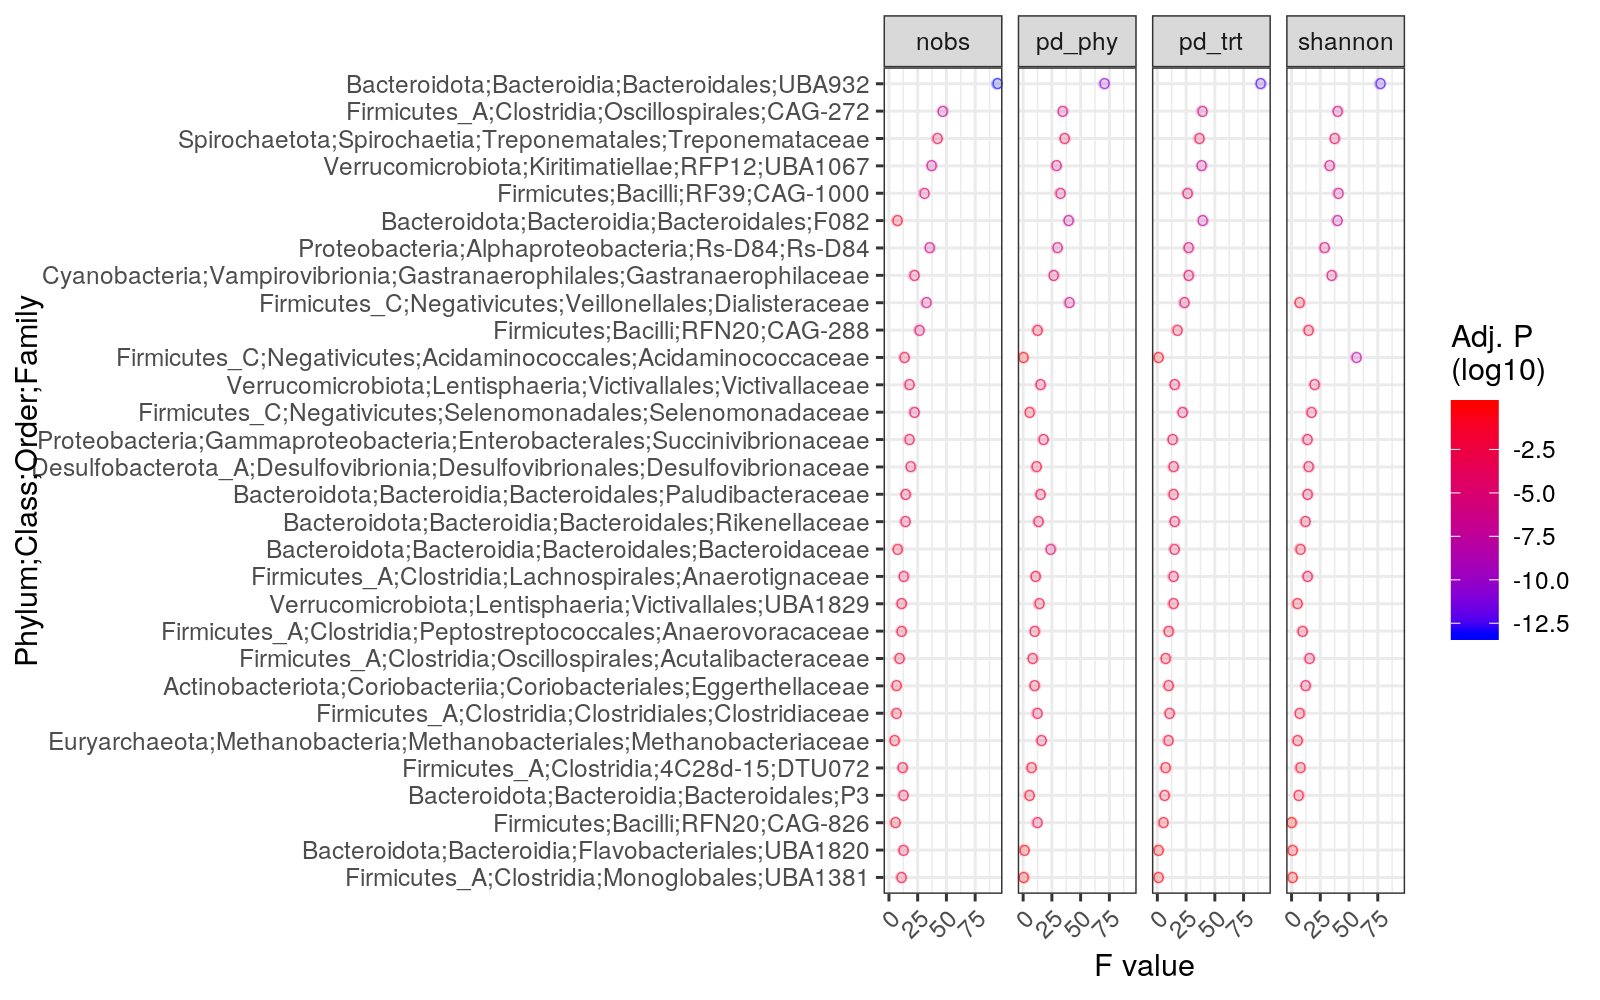

In [69]:
p = lmer_res %>%
#     dt_mutate(is_na = any(is.na(F_value)),
#               by=list(Clade)) %>%
#     dt_filter(is_na == FALSE, Padj < 0.01) %>%
#     dt_mutate(n_metric = length(unique(Metric)), by=list(Clade)) %>%
#     dt_filter(n_metric == 4) %>%
    dt_mutate(any_sig = any(Padj < 0.01), by=list(Clade)) %>%
    dt_filter(any_sig == TRUE) %>%
    dt_mutate(mean_F = mean(F_value), by=list(Clade)) %>%
    dt_mutate(Clade = gsub('___', ';', Clade),
              Clade = gsub('^(Bacteria|Archaea);', '', Clade),
              Clade = Clade %>% reorder(mean_F)) %>%
    ggplot(aes(Clade, F_value, color=log10(Padj))) +
    geom_point(alpha=0.2) +
    geom_point(alpha=0.6, shape='O') +
    scale_color_continuous('Adj. P\n(log10)', low='blue', high='red') +
    labs(x='Phylum;Class;Order;Family', y='F value') +
    facet_grid(. ~ Metric) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    ) +
    coord_flip() 

p.dims(8,5)
plot(p)

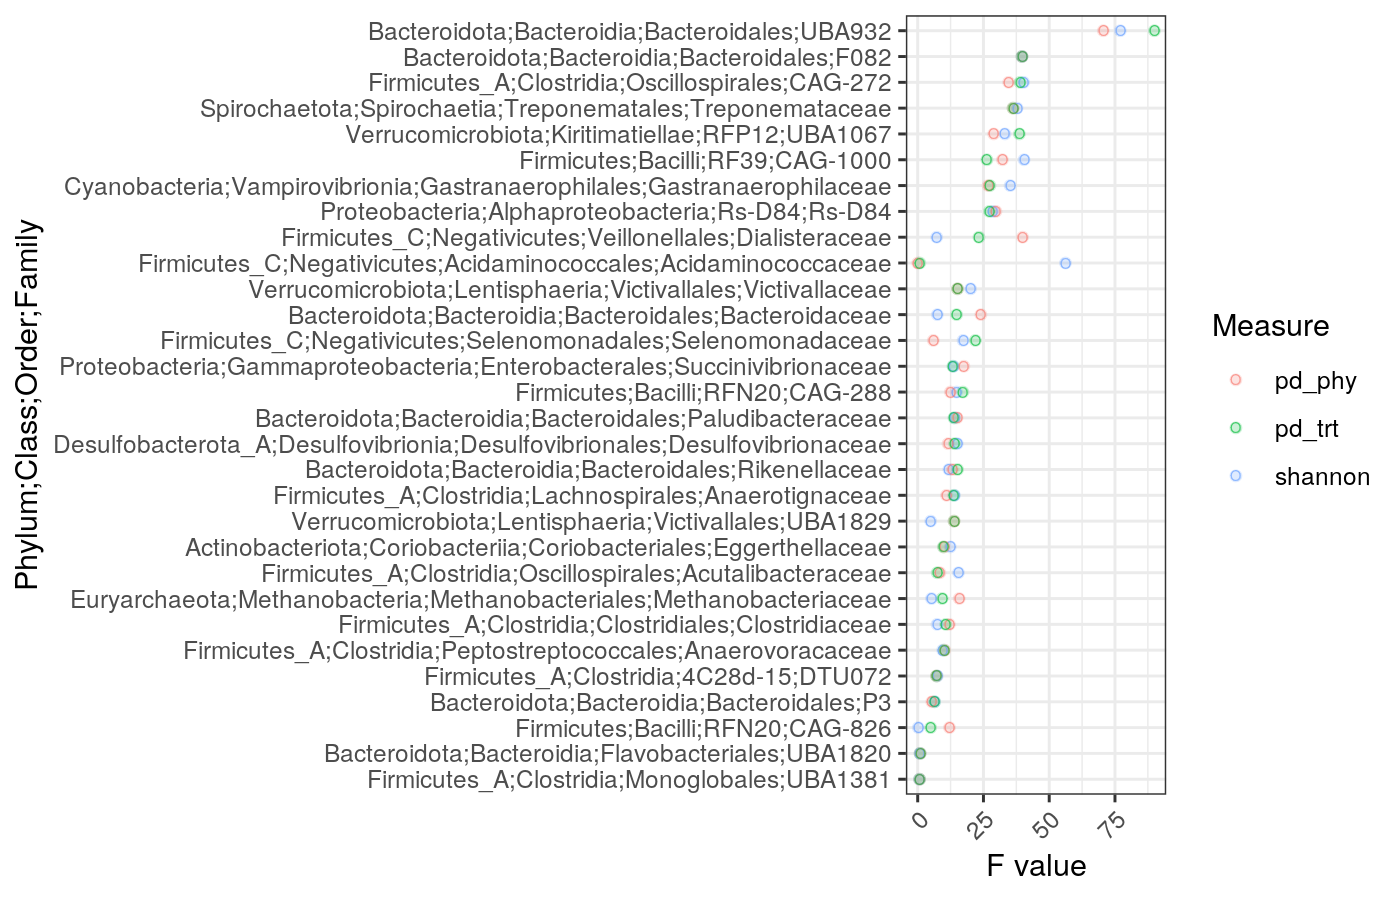

In [70]:
p = lmer_res %>%
    dt_mutate(any_sig = any(Padj < 0.01), by=list(Clade)) %>%
    dt_filter(any_sig == TRUE, Metric != 'nobs') %>%
    dt_mutate(mean_F = mean(F_value), by=list(Clade)) %>%
    dt_mutate(Clade = gsub('___', ';', Clade),
              Clade = gsub('^(Bacteria|Archaea);', '', Clade),
              Clade = Clade %>% reorder(mean_F)) %>%
    ggplot(aes(Clade, F_value, color=Metric)) +
    geom_point(alpha=0.2) +
    geom_point(alpha=0.6, shape='O') +
    scale_color_discrete('Measure') +
    labs(x='Phylum;Class;Order;Family', y='F value') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    ) +
    coord_flip() 

p.dims(7,4.5)
plot(p)

# lmer: filtered

In [132]:
# filtering
alpha_div_f = alpha_div %>%
    dt_filter(!is.na(study_condition),
              !is.na(gender),
              !is.na(age)) %>%
    dt_mutate(age = log2(age))

alpha_div %>% unique_n('Samples', Sample)
alpha_div_f %>% unique_n('Samples', Sample)
alpha_div %>% unique_n('datasets', dataset_name)
alpha_div_f %>% unique_n('datasets', dataset_name)

No. of unique Samples: 3348 
No. of unique Samples: 1843 
No. of unique datasets: 33 
No. of unique datasets: 17 


In [133]:
# pairwise combinations of clade & div_metric
clades = alpha_div %>% dt_pull(Clade) %>% unique
metrics = alpha_div %>% dt_pull(Metric) %>% unique
x = expand.grid(metrics, clades) 
colnames(x) = c('Metric', 'Clade')
x$iter = 1:nrow(x)

# calculation
Form = 'Metric_value ~ westernized + age + gender + (1 | dataset_name)'
doParallel::registerDoParallel(threads)
lmer_res = x %>% 
    dt_group_split(iter) %>%
    plyr::llply(calc_lm, alpha_div=alpha_div_f, Form=Form, .parallel=TRUE) %>%
    data.table::rbindlist(use.names=TRUE)

# formatting
colnames(lmer_res) = c('Sum_sq', 'Mean_sq', 'NumDF', 'DenDF', 
                       'F_value', 'P', 'Clade', 'Metric', 'Variable')
lmer_res = lmer_res %>%
    dt_mutate(P = P %>% as.Num,
              Padj = p.adjust(P, method='BH'))

# summary
lmer_res %>% unique_n('Clades', Clade)
lmer_res %>% unique_n('Metrics', Metric)
lmer_res

No. of unique Clades: 136 
No. of unique Metrics: 4 


Sum_sq,Mean_sq,NumDF,DenDF,F_value,P,Clade,Metric,Variable,Padj
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
2826.946,2826.946,1,51.46889,16.55732,1.626383e-04,Bacteria___Firmicutes_A___Clostridia___Oscillospirales___Oscillospiraceae,nobs,westernized,0.0023727295
2950.248,2950.248,1,1777.59076,17.27950,3.379947e-05,Bacteria___Firmicutes_A___Clostridia___Oscillospirales___Oscillospiraceae,nobs,age,0.0005991303
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
NA,NA,NA,NA,NA,NA,Bacteria___Firmicutes_A___Clostridia___Saccharofermentanales___Saccharofermentanaceae,pd_phy,westernized,NA
NA,NA,NA,NA,NA,NA,Bacteria___Firmicutes_A___Clostridia___Saccharofermentanales___Saccharofermentanaceae,pd_trt,westernized,NA


In [134]:
# Summary of P-values
lmer_res %>% dt_pull(P) %>% summary_x('P')
lmer_res %>% dt_pull(Padj) %>% summary_x('Padj')

,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,NA's,sd,sd_err_of_mean
P,3.149766e-36,0.03974662,0.2530289,0.3351934,0.5675799,1,118,44.463,16.805


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.,NA's,sd,sd_err_of_mean
Padj,1.3586e-33,0.158618,0.505642,0.4823806,0.7565781,1,118,44.418,16.789


Warning message:
“Removed 118 rows containing missing values (geom_point).”


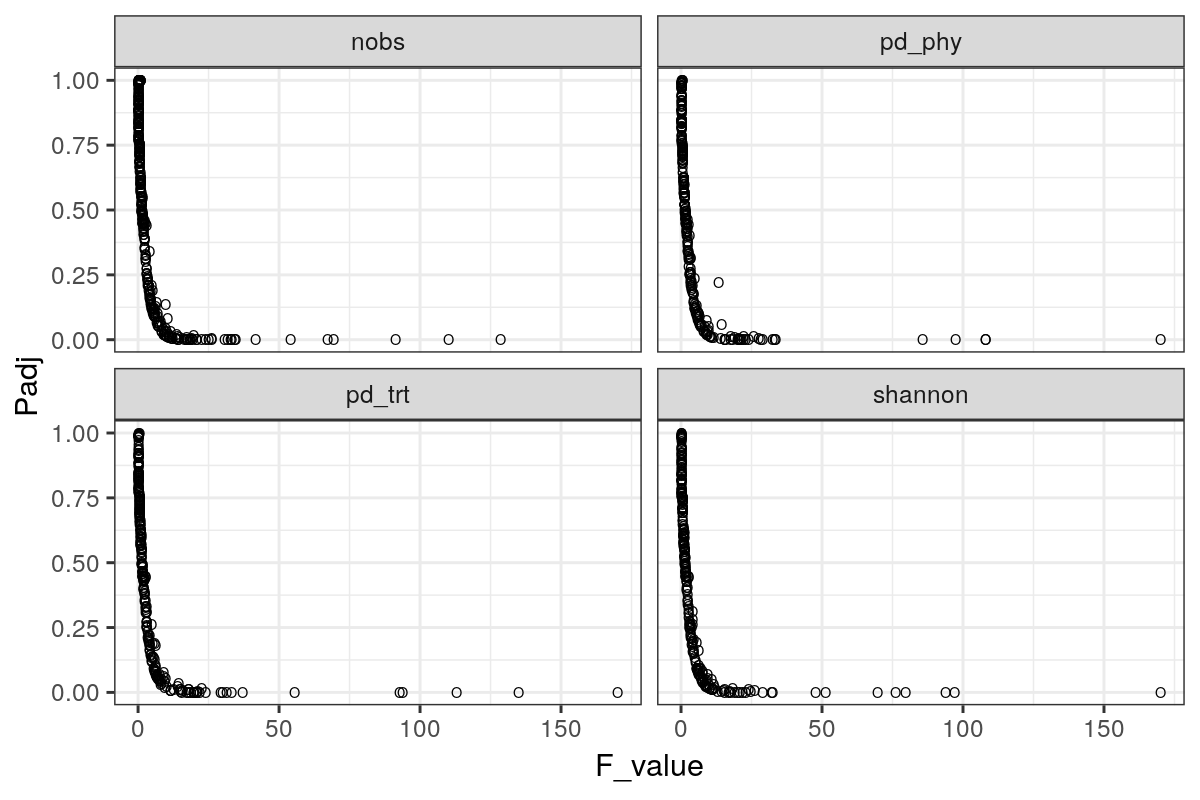

In [135]:
p = lmer_res %>%
    ggplot(aes(F_value, Padj)) +
    geom_point(shape='O') +
    facet_wrap(~ Metric) +
    theme_bw()

p.dims(6,4)
plot(p)

## Plotting

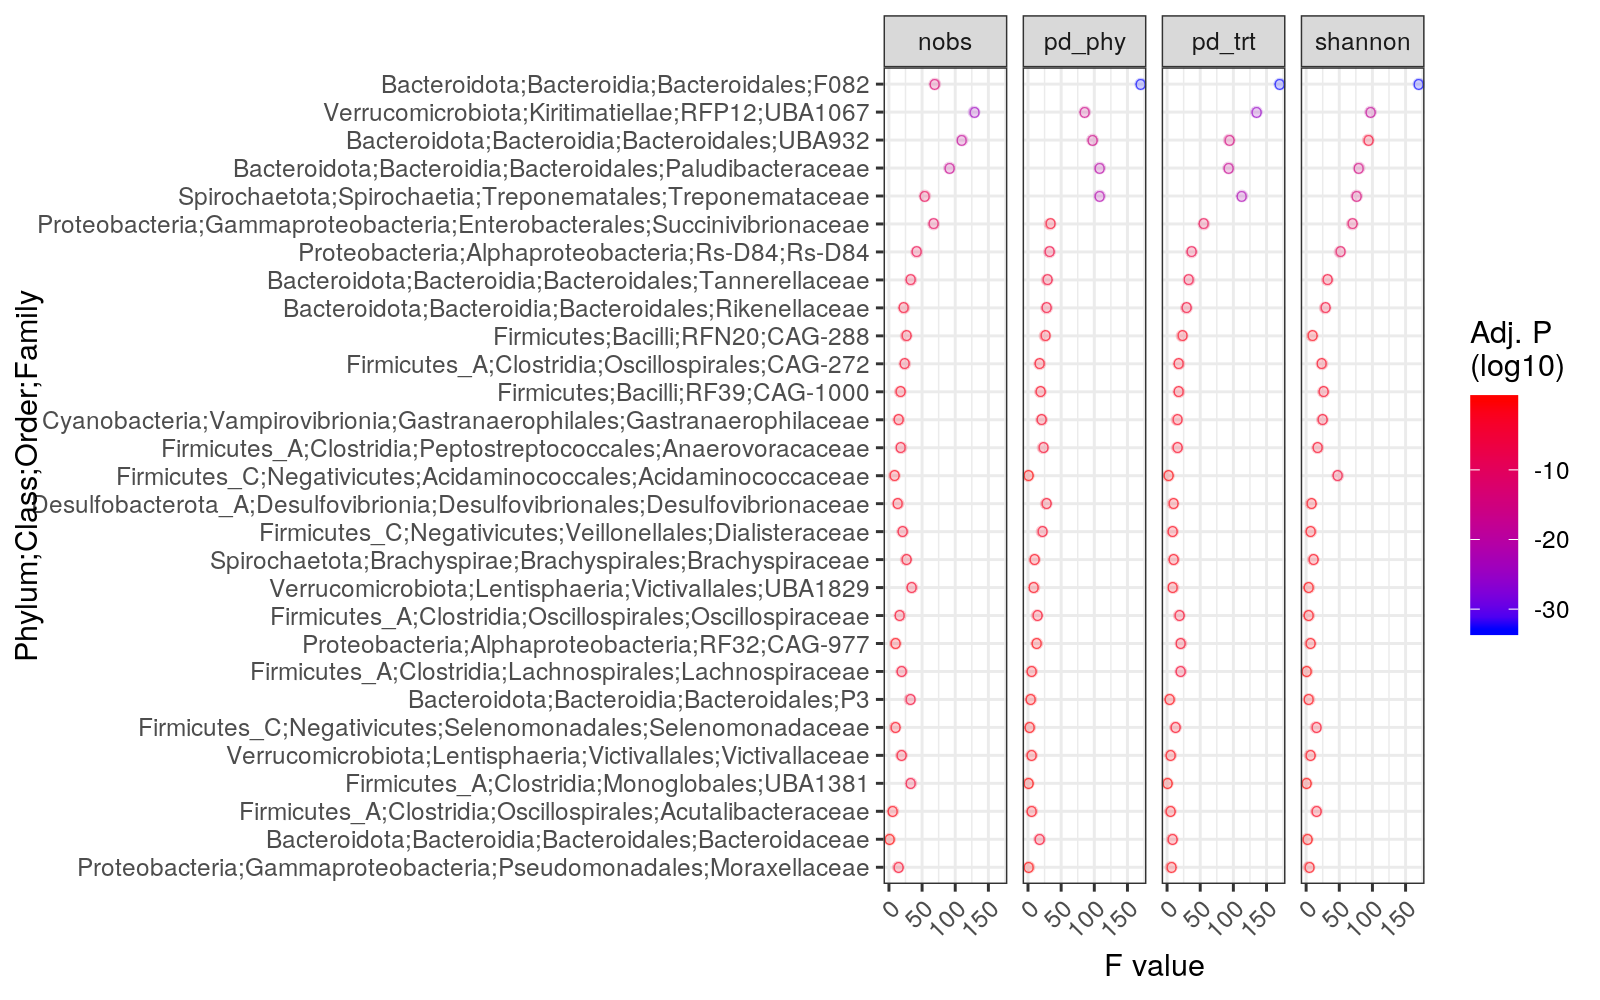

In [136]:
# westernization
p = lmer_res %>%
    dt_filter(Variable == 'westernized') %>%
    dt_mutate(sig = Padj < 0.01) %>%
    dt_mutate(any_sig = any(sig), by=list(Clade)) %>%
    dt_filter(any_sig == TRUE) %>%
    dt_mutate(mean_F = mean(F_value, na.rm=TRUE), by=list(Clade)) %>%
    dt_mutate(Clade = gsub('___', ';', Clade),
              Clade = gsub('^(Bacteria|Archaea);', '', Clade),
              Clade = Clade %>% reorder(mean_F)) %>%
    ggplot(aes(Clade, F_value, color=log10(Padj))) +
    geom_point(alpha=0.2) +
    geom_point(alpha=0.6, shape='O') +
    scale_color_continuous('Adj. P\n(log10)', low='blue', high='red') +
    labs(x='Phylum;Class;Order;Family', y='F value') +
    facet_grid(. ~ Metric) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    ) +
    coord_flip() 

p.dims(8,5)
plot(p)

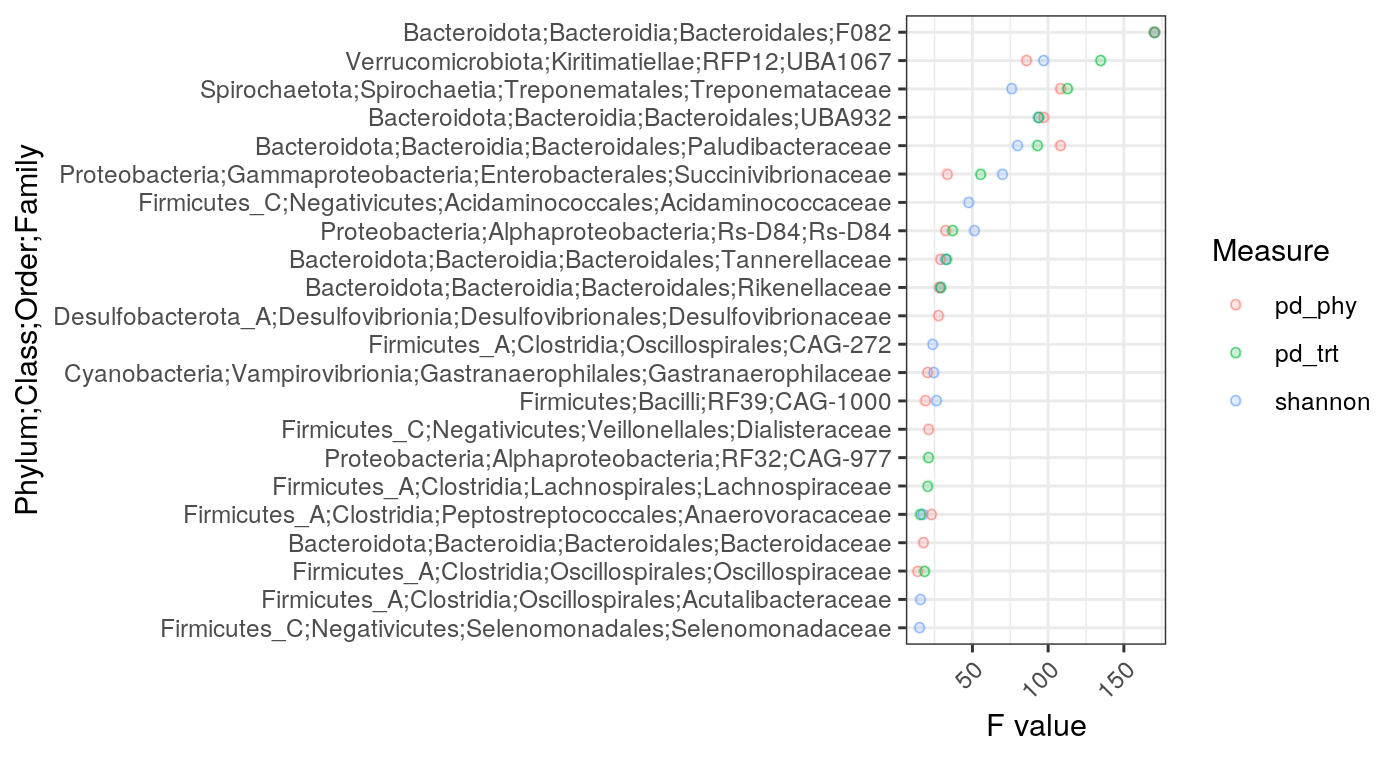

In [137]:
p = lmer_res %>%
    dt_filter(Variable == 'westernized') %>%
    dt_filter(Metric != 'nobs') %>%
    dt_filter(Padj < 0.01) %>%
    dt_mutate(mean_F = mean(F_value), by=list(Clade)) %>%
    dt_mutate(Clade = gsub('___', ';', Clade),
              Clade = gsub('^(Bacteria|Archaea);', '', Clade),
              Clade = Clade %>% reorder(mean_F)) %>%
    ggplot(aes(Clade, F_value, color=Metric)) +
    geom_point(alpha=0.2) +
    geom_point(alpha=0.6, shape='O') +
    scale_color_discrete('Measure') +
    labs(x='Phylum;Class;Order;Family', y='F value') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    ) +
    coord_flip() 

p.dims(7,3.8)
plot(p)

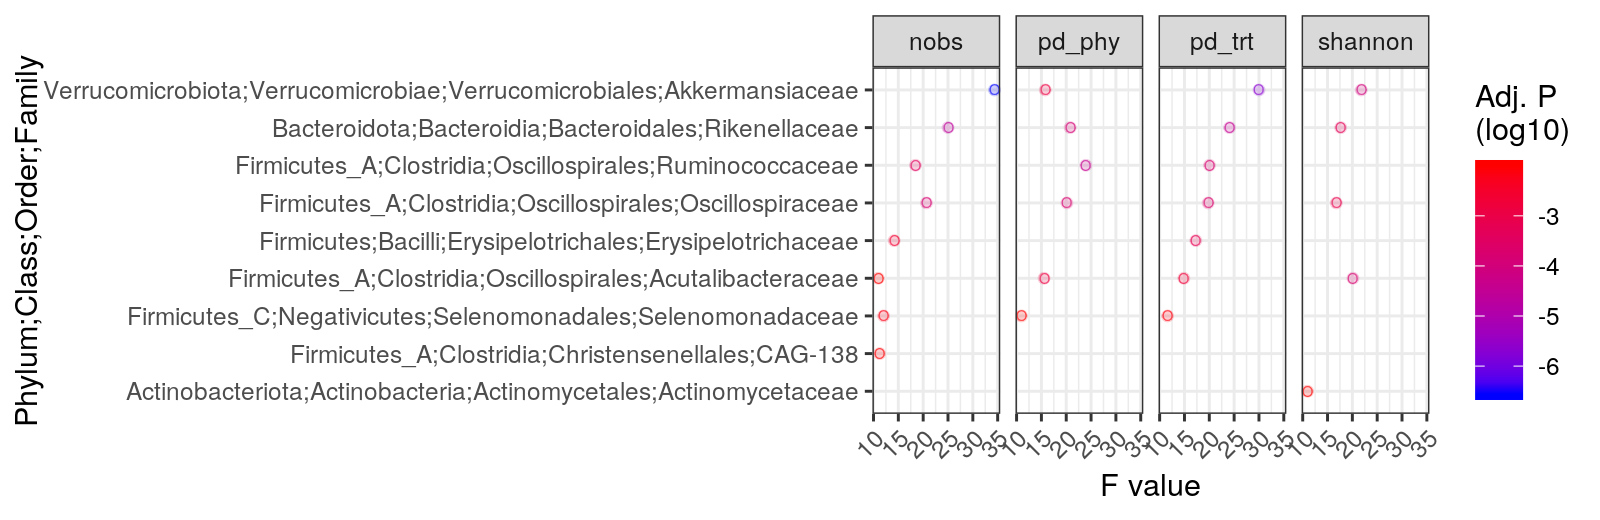

In [138]:
# gender
p = lmer_res %>%
    dt_filter(Variable == 'gender') %>%
    dt_filter(Padj < 0.01) %>%
    dt_mutate(mean_F = mean(F_value, na.rm=TRUE), by=list(Clade)) %>%
    dt_mutate(Clade = gsub('___', ';', Clade),
              Clade = gsub('^(Bacteria|Archaea);', '', Clade),
              Clade = Clade %>% reorder(mean_F)) %>%
    ggplot(aes(Clade, F_value, color=log10(Padj))) +
    geom_point(alpha=0.2) +
    geom_point(alpha=0.6, shape='O') +
    scale_color_continuous('Adj. P\n(log10)', low='blue', high='red') +
    labs(x='Phylum;Class;Order;Family', y='F value') +
    facet_grid(. ~ Metric) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    ) +
    coord_flip() 

p.dims(8,2.6)
plot(p)

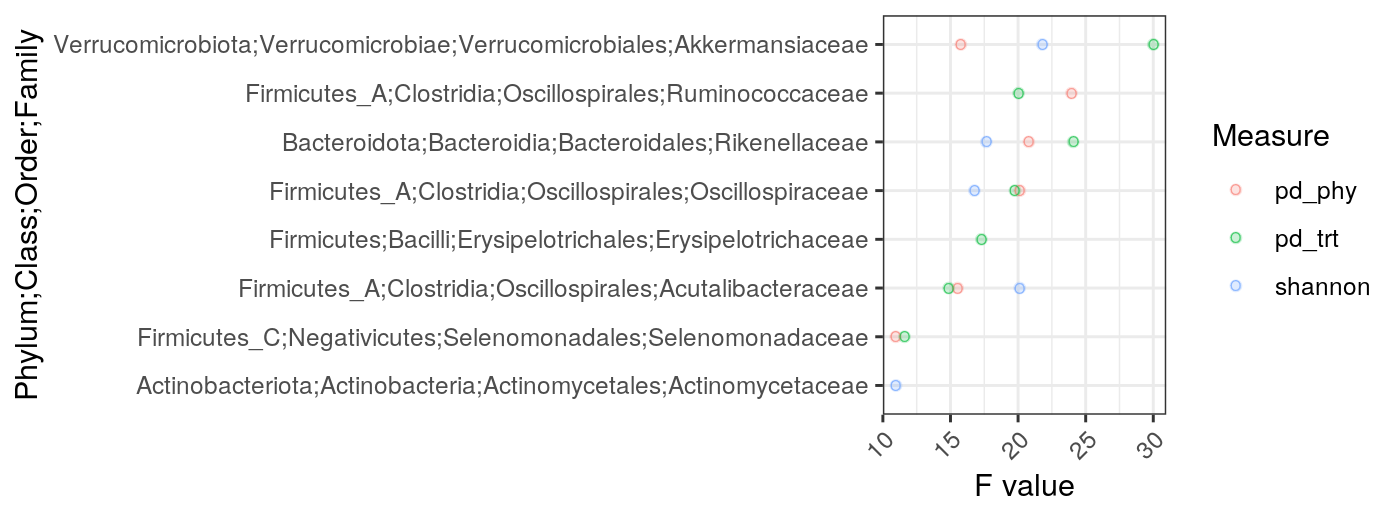

In [139]:
p = lmer_res %>%
    dt_filter(Variable == 'gender') %>%
    dt_filter(Metric != 'nobs') %>%
    dt_filter(Padj < 0.01) %>%
    dt_mutate(mean_F = mean(F_value), by=list(Clade)) %>%
    dt_mutate(Clade = gsub('___', ';', Clade),
              Clade = gsub('^(Bacteria|Archaea);', '', Clade),
              Clade = Clade %>% reorder(mean_F)) %>%
    ggplot(aes(Clade, F_value, color=Metric)) +
    geom_point(alpha=0.2) +
    geom_point(alpha=0.6, shape='O') +
    scale_color_discrete('Measure') +
    labs(x='Phylum;Class;Order;Family', y='F value') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    ) +
    coord_flip() 

p.dims(7,2.6)
plot(p)

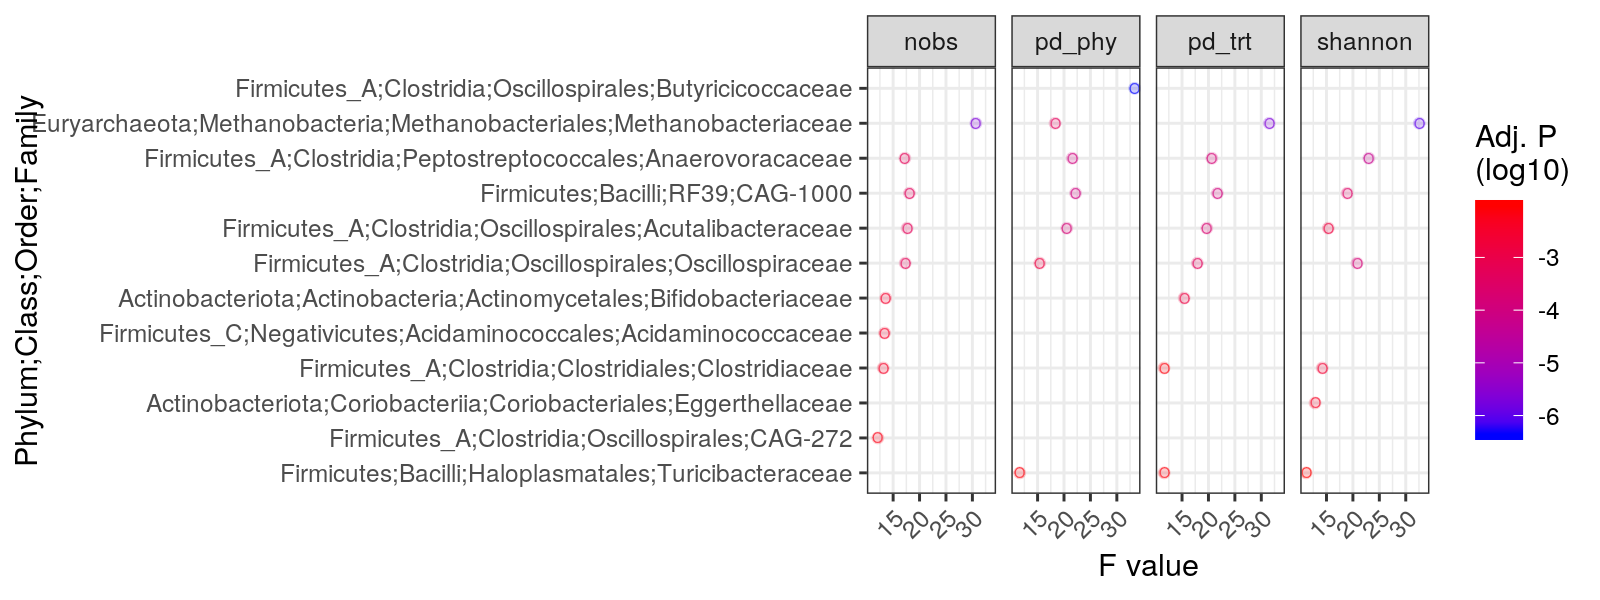

In [140]:
# age
p = lmer_res %>%
    dt_filter(Variable == 'age') %>%
    dt_filter(Padj < 0.01) %>%
    dt_mutate(mean_F = mean(F_value, na.rm=TRUE), by=list(Clade)) %>%
    dt_mutate(Clade = gsub('___', ';', Clade),
              Clade = gsub('^(Bacteria|Archaea);', '', Clade),
              Clade = Clade %>% reorder(mean_F)) %>%
    ggplot(aes(Clade, F_value, color=log10(Padj))) +
    geom_point(alpha=0.2) +
    geom_point(alpha=0.6, shape='O') +
    scale_color_continuous('Adj. P\n(log10)', low='blue', high='red') +
    labs(x='Phylum;Class;Order;Family', y='F value') +
    facet_grid(. ~ Metric) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    ) +
    coord_flip() 

p.dims(8,3)
plot(p)

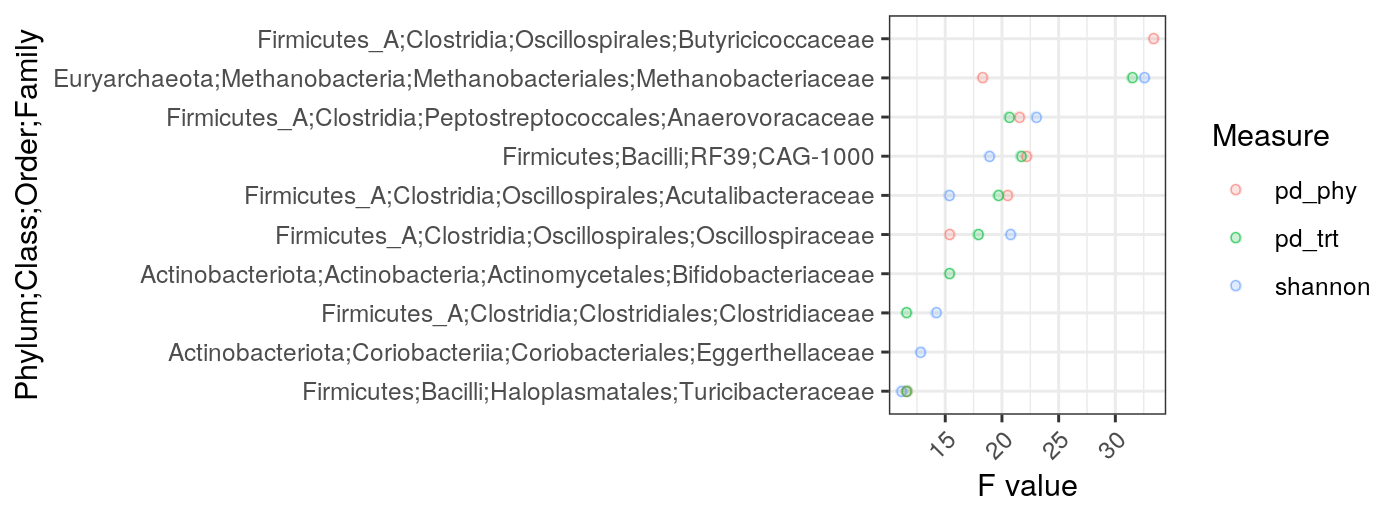

In [141]:
p = lmer_res %>%
    dt_filter(Variable == 'age') %>%
    dt_filter(Metric != 'nobs') %>%
    dt_filter(Padj < 0.01) %>%
    dt_mutate(mean_F = mean(F_value), by=list(Clade)) %>%
    dt_mutate(Clade = gsub('___', ';', Clade),
              Clade = gsub('^(Bacteria|Archaea);', '', Clade),
              Clade = Clade %>% reorder(mean_F)) %>%
    ggplot(aes(Clade, F_value, color=Metric)) +
    geom_point(alpha=0.2) +
    geom_point(alpha=0.6, shape='O') +
    scale_color_discrete('Measure') +
    labs(x='Phylum;Class;Order;Family', y='F value') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    ) +
    coord_flip() 

p.dims(7,2.6)
plot(p)

# lmer: filtered2

In [142]:
# filtering
alpha_div_f = alpha_div %>%
    dt_filter(!is.na(study_condition),
              !is.na(gender),
              !is.na(age),
              !is.na(BMI)) %>%
    dt_mutate(age = log2(age))

alpha_div %>% unique_n('Samples', Sample)
alpha_div_f %>% unique_n('Samples', Sample)
alpha_div %>% unique_n('datasets', dataset_name)
alpha_div_f %>% unique_n('datasets', dataset_name)

No. of unique Samples: 3348 
No. of unique Samples: 935 
No. of unique datasets: 33 
No. of unique datasets: 11 


In [143]:
# pairwise combinations of clade & div_metric
clades = alpha_div %>% dt_pull(Clade) %>% unique
metrics = alpha_div %>% dt_pull(Metric) %>% unique
x = expand.grid(metrics, clades) 
colnames(x) = c('Metric', 'Clade')
x$iter = 1:nrow(x)

# calculation
Form = 'Metric_value ~ westernized + age + gender + BMI + (1 | dataset_name)'
doParallel::registerDoParallel(threads)
lmer_res = x %>% 
    dt_group_split(iter) %>%
    plyr::llply(calc_lm, alpha_div=alpha_div_f, Form=Form, .parallel=TRUE) %>%
    data.table::rbindlist(use.names=TRUE)

# formatting
colnames(lmer_res) = c('Sum_sq', 'Mean_sq', 'NumDF', 'DenDF', 
                       'F_value', 'P', 'Clade', 'Metric', 'Variable')
lmer_res = lmer_res %>%
    dt_mutate(P = P %>% as.Num,
              Padj = p.adjust(P, method='BH'))

# summary
lmer_res %>% unique_n('Clades', Clade)
lmer_res %>% unique_n('Metrics', Metric)
lmer_res

No. of unique Clades: 136 
No. of unique Metrics: 4 


Sum_sq,Mean_sq,NumDF,DenDF,F_value,P,Clade,Metric,Variable,Padj
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
2083.577,2083.577,1,80.56646,13.02937,5.310351e-04,Bacteria___Firmicutes_A___Clostridia___Oscillospirales___Oscillospiraceae,nobs,westernized,6.342200e-03
4064.431,4064.431,1,928.95207,25.41637,5.553266e-07,Bacteria___Firmicutes_A___Clostridia___Oscillospirales___Oscillospiraceae,nobs,age,1.539198e-05
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
NA,NA,NA,NA,NA,NA,Bacteria___Firmicutes_A___Clostridia___Saccharofermentanales___Saccharofermentanaceae,pd_phy,westernized,NA
NA,NA,NA,NA,NA,NA,Bacteria___Firmicutes_A___Clostridia___Saccharofermentanales___Saccharofermentanaceae,pd_trt,westernized,NA


## Plotting

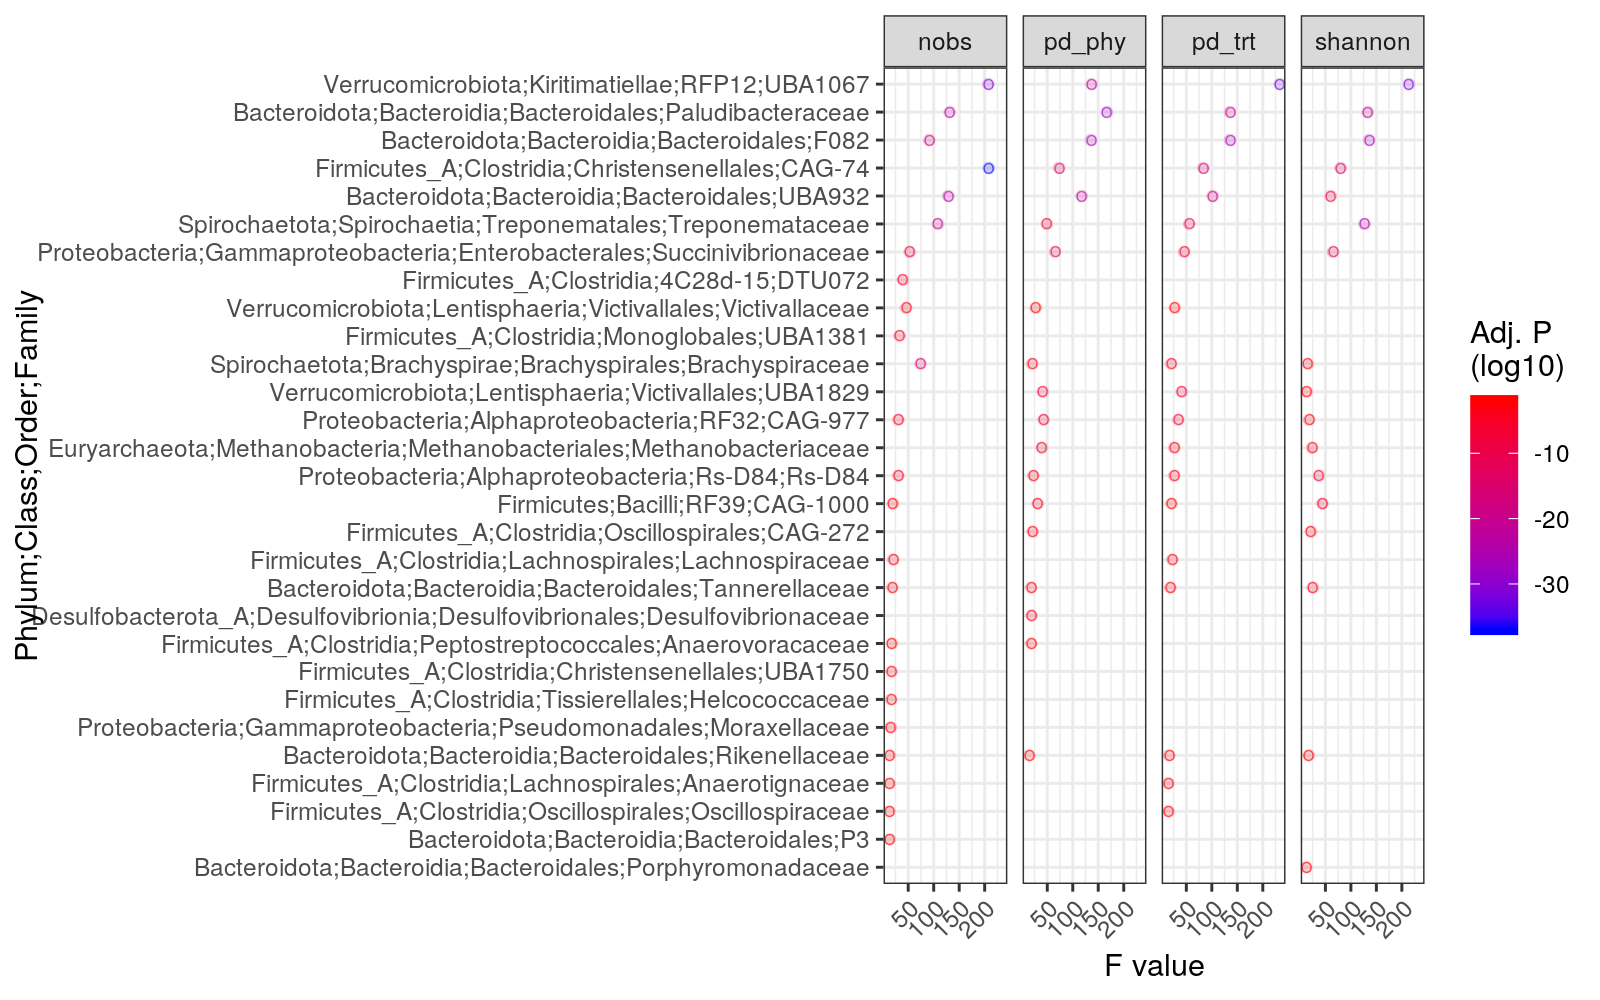

In [144]:
# westernization
p = lmer_res %>%
     dt_filter(Variable == 'westernized') %>%
    dt_filter(Padj < 0.01) %>%
    dt_mutate(mean_F = mean(F_value, na.rm=TRUE), by=list(Clade)) %>%
    dt_mutate(Clade = gsub('___', ';', Clade),
              Clade = gsub('^(Bacteria|Archaea);', '', Clade),
              Clade = Clade %>% reorder(mean_F)) %>%
    ggplot(aes(Clade, F_value, color=log10(Padj))) +
    geom_point(alpha=0.2) +
    geom_point(alpha=0.6, shape='O') +
    scale_color_continuous('Adj. P\n(log10)', low='blue', high='red') +
    labs(x='Phylum;Class;Order;Family', y='F value') +
    facet_grid(. ~ Metric) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    ) +
    coord_flip() 

p.dims(8,5)
plot(p)

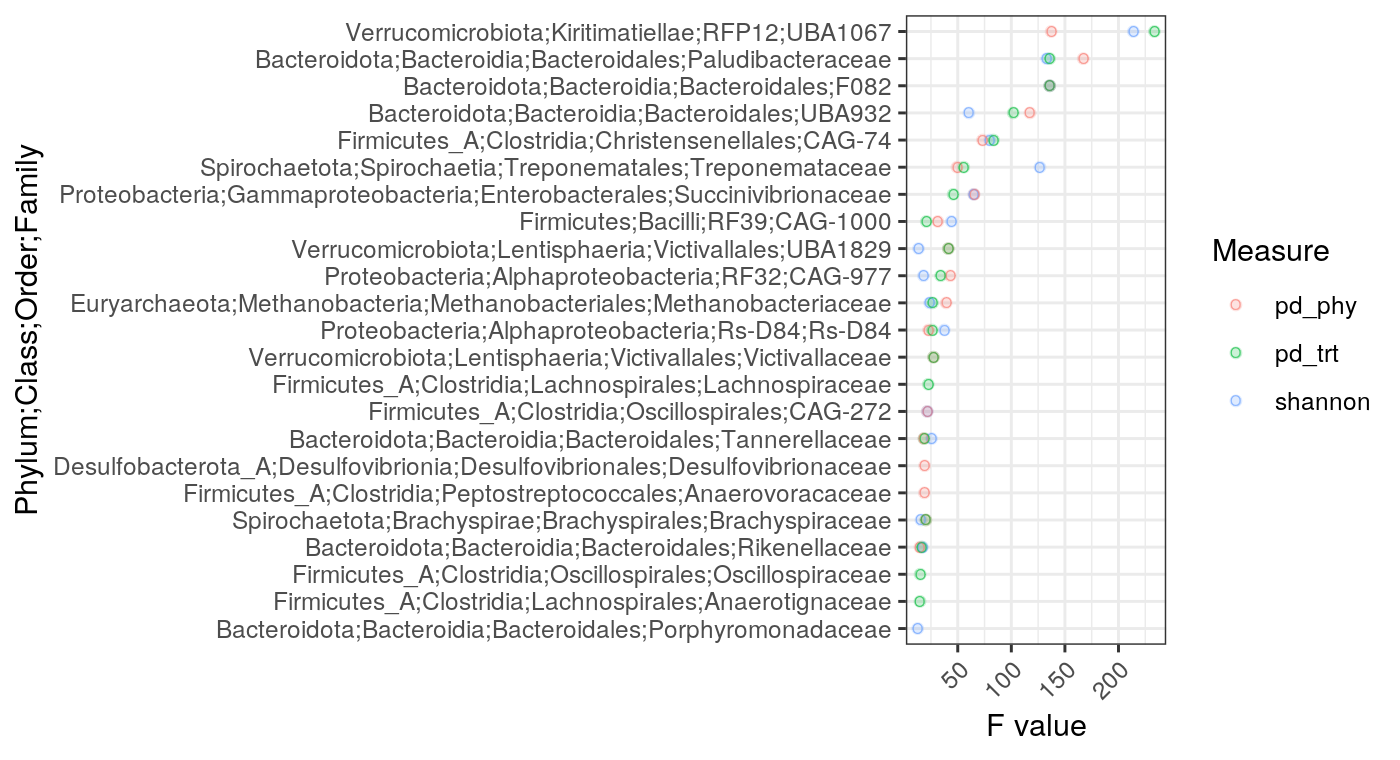

In [145]:
p = lmer_res %>%
    dt_filter(Variable == 'westernized') %>%
    dt_filter(Metric != 'nobs') %>%
    dt_filter(Padj < 0.01) %>%
    dt_mutate(mean_F = mean(F_value), by=list(Clade)) %>%
    dt_mutate(Clade = gsub('___', ';', Clade),
              Clade = gsub('^(Bacteria|Archaea);', '', Clade),
              Clade = Clade %>% reorder(mean_F)) %>%
    ggplot(aes(Clade, F_value, color=Metric)) +
    geom_point(alpha=0.2) +
    geom_point(alpha=0.6, shape='O') +
    scale_color_discrete('Measure') +
    labs(x='Phylum;Class;Order;Family', y='F value') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    ) +
    coord_flip() 

p.dims(7,3.8)
plot(p)

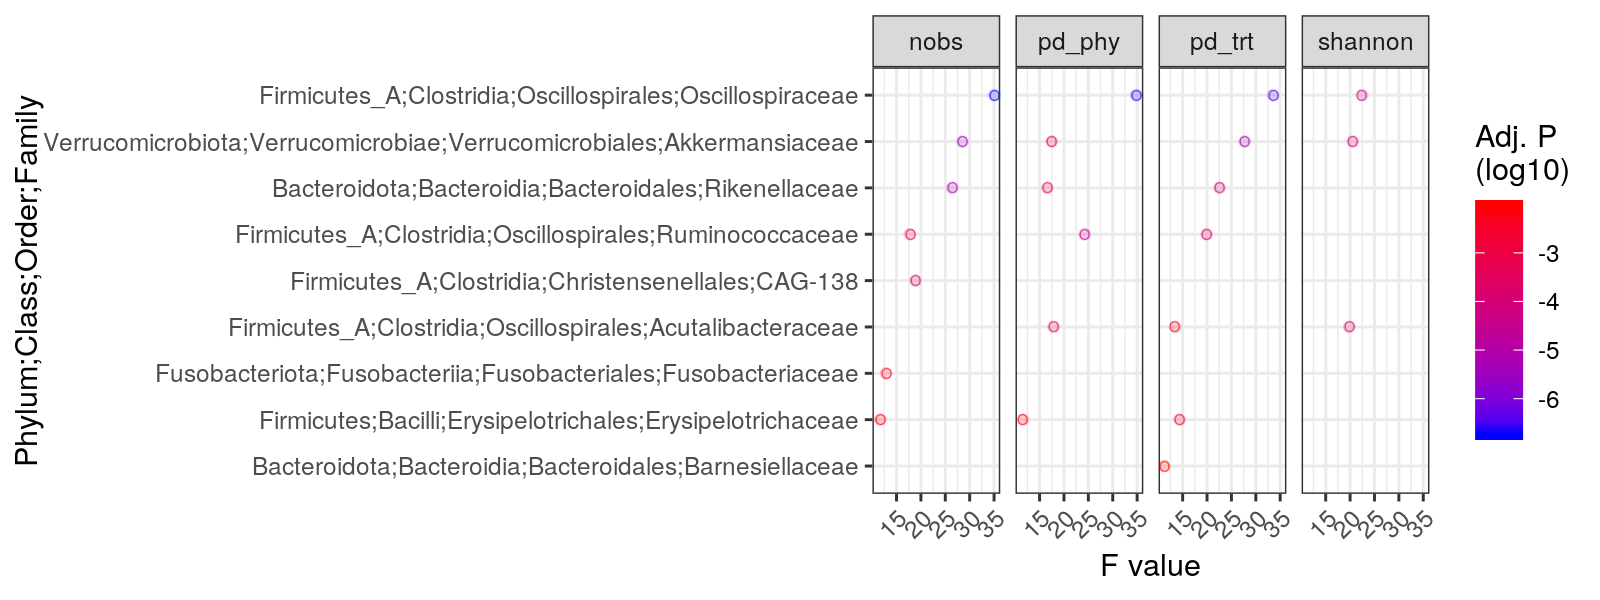

In [146]:
# gender
p = lmer_res %>%
     dt_filter(Variable == 'gender') %>%
    dt_filter(Padj < 0.01) %>%
    dt_mutate(mean_F = mean(F_value, na.rm=TRUE), by=list(Clade)) %>%
    dt_mutate(Clade = gsub('___', ';', Clade),
              Clade = gsub('^(Bacteria|Archaea);', '', Clade),
              Clade = Clade %>% reorder(mean_F)) %>%
    ggplot(aes(Clade, F_value, color=log10(Padj))) +
    geom_point(alpha=0.2) +
    geom_point(alpha=0.6, shape='O') +
    scale_color_continuous('Adj. P\n(log10)', low='blue', high='red') +
    labs(x='Phylum;Class;Order;Family', y='F value') +
    facet_grid(. ~ Metric) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    ) +
    coord_flip() 

p.dims(8,3)
plot(p)

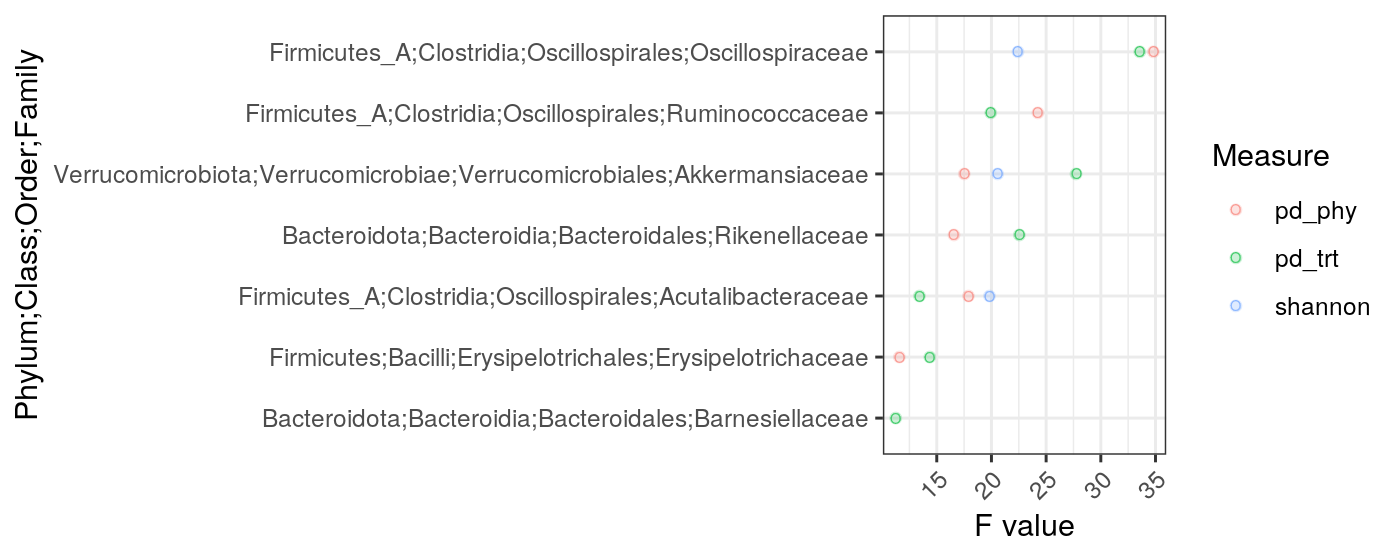

In [147]:
p = lmer_res %>%
    dt_filter(Variable == 'gender') %>%
    dt_filter(Metric != 'nobs') %>%
    dt_filter(Padj < 0.01) %>%
    dt_mutate(mean_F = mean(F_value), by=list(Clade)) %>%
    dt_mutate(Clade = gsub('___', ';', Clade),
              Clade = gsub('^(Bacteria|Archaea);', '', Clade),
              Clade = Clade %>% reorder(mean_F)) %>%
    ggplot(aes(Clade, F_value, color=Metric)) +
    geom_point(alpha=0.2) +
    geom_point(alpha=0.6, shape='O') +
    scale_color_discrete('Measure') +
    labs(x='Phylum;Class;Order;Family', y='F value') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    ) +
    coord_flip() 

p.dims(7,2.8)
plot(p)

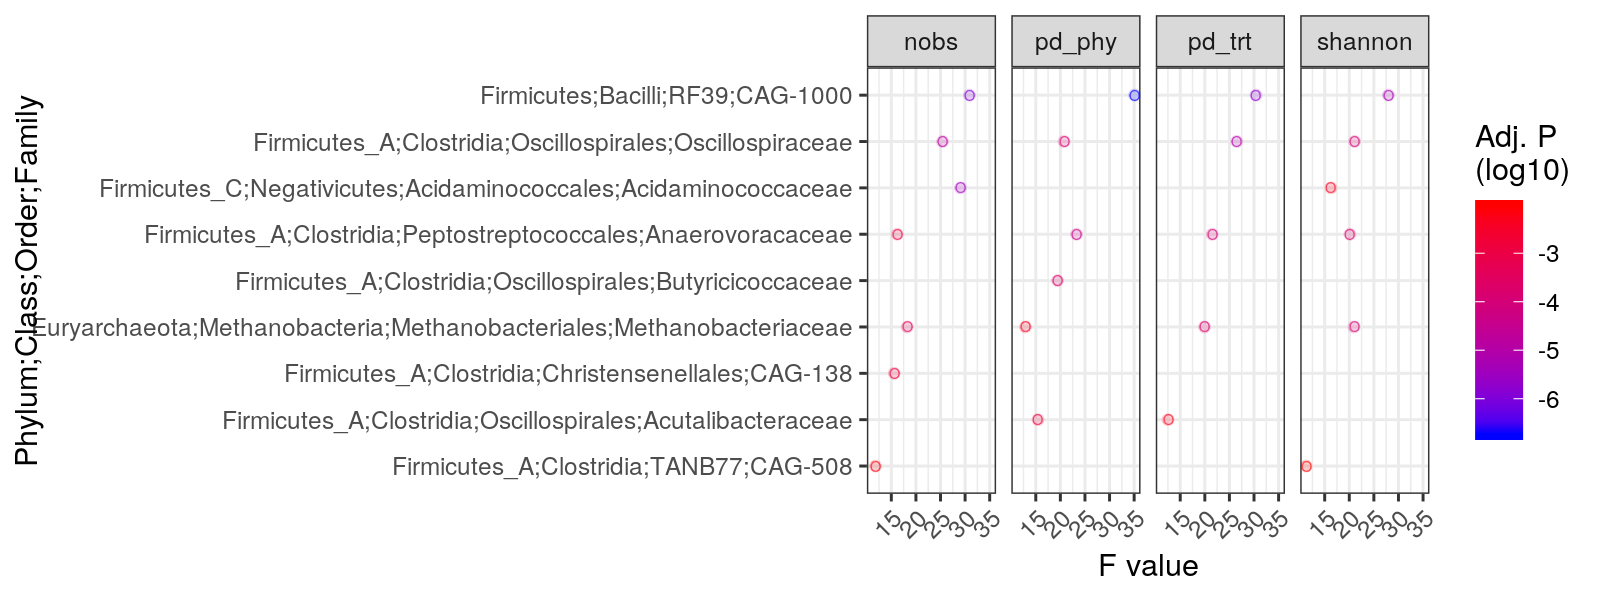

In [148]:
# age
p = lmer_res %>%
     dt_filter(Variable == 'age') %>%
    dt_filter(Padj < 0.01) %>%
    dt_mutate(mean_F = mean(F_value, na.rm=TRUE), by=list(Clade)) %>%
    dt_mutate(Clade = gsub('___', ';', Clade),
              Clade = gsub('^(Bacteria|Archaea);', '', Clade),
              Clade = Clade %>% reorder(mean_F)) %>%
    ggplot(aes(Clade, F_value, color=log10(Padj))) +
    geom_point(alpha=0.2) +
    geom_point(alpha=0.6, shape='O') +
    scale_color_continuous('Adj. P\n(log10)', low='blue', high='red') +
    labs(x='Phylum;Class;Order;Family', y='F value') +
    facet_grid(. ~ Metric) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    ) +
    coord_flip() 

p.dims(8,3)
plot(p)

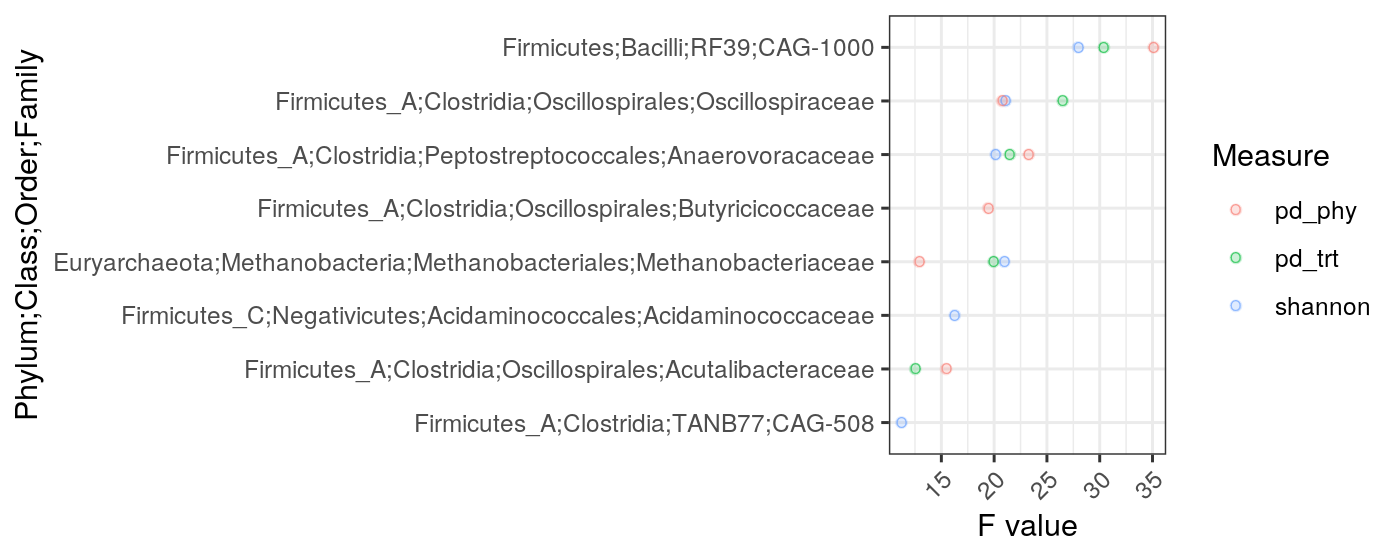

In [149]:
p = lmer_res %>%
    dt_filter(Variable == 'age') %>%
    dt_filter(Metric != 'nobs') %>%
    dt_filter(Padj < 0.01) %>%
    dt_mutate(mean_F = mean(F_value), by=list(Clade)) %>%
    dt_mutate(Clade = gsub('___', ';', Clade),
              Clade = gsub('^(Bacteria|Archaea);', '', Clade),
              Clade = Clade %>% reorder(mean_F)) %>%
    ggplot(aes(Clade, F_value, color=Metric)) +
    geom_point(alpha=0.2) +
    geom_point(alpha=0.6, shape='O') +
    scale_color_discrete('Measure') +
    labs(x='Phylum;Class;Order;Family', y='F value') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    ) +
    coord_flip() 

p.dims(7,2.8)
plot(p)

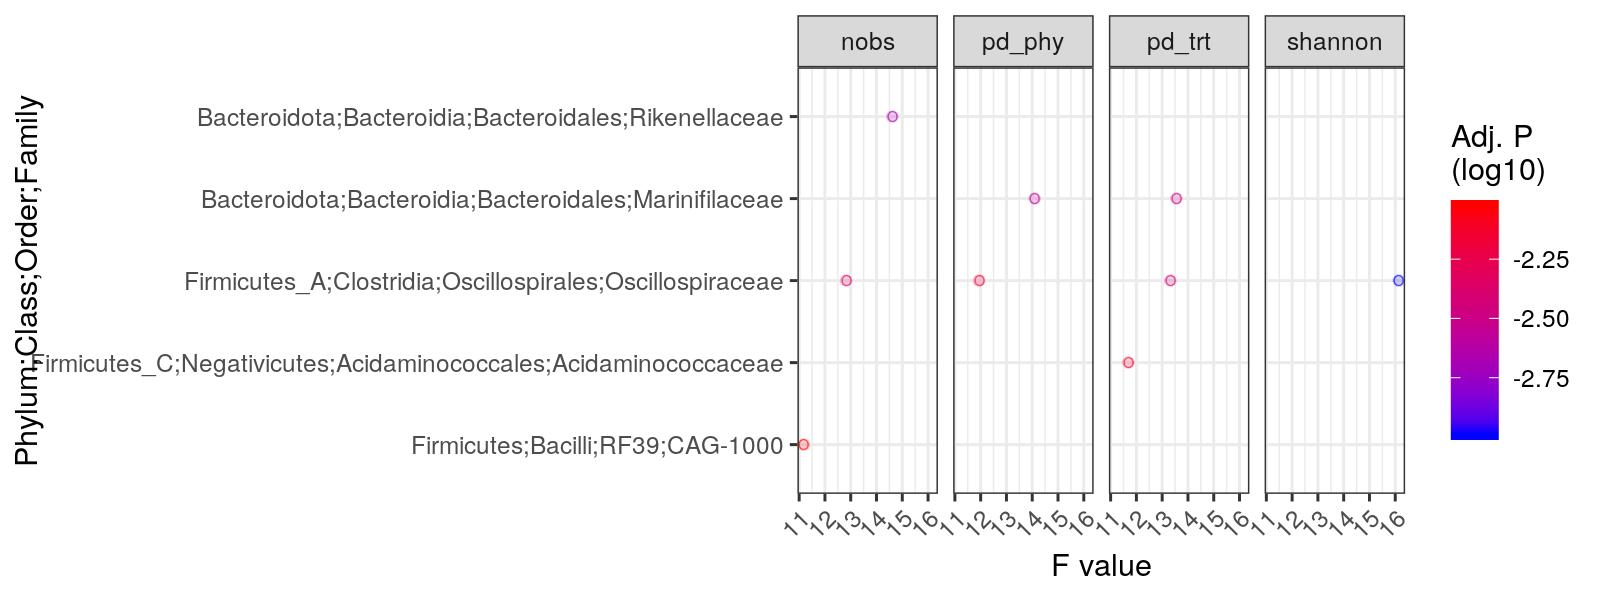

In [150]:
# BMI
p = lmer_res %>%
     dt_filter(Variable == 'BMI') %>%
    dt_filter(Padj < 0.01) %>%
    dt_mutate(mean_F = mean(F_value, na.rm=TRUE), by=list(Clade)) %>%
    dt_mutate(Clade = gsub('___', ';', Clade),
              Clade = gsub('^(Bacteria|Archaea);', '', Clade),
              Clade = Clade %>% reorder(mean_F)) %>%
    ggplot(aes(Clade, F_value, color=log10(Padj))) +
    geom_point(alpha=0.2) +
    geom_point(alpha=0.6, shape='O') +
    scale_color_continuous('Adj. P\n(log10)', low='blue', high='red') +
    labs(x='Phylum;Class;Order;Family', y='F value') +
    facet_grid(. ~ Metric) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    ) +
    coord_flip() 

p.dims(8,3)
plot(p)

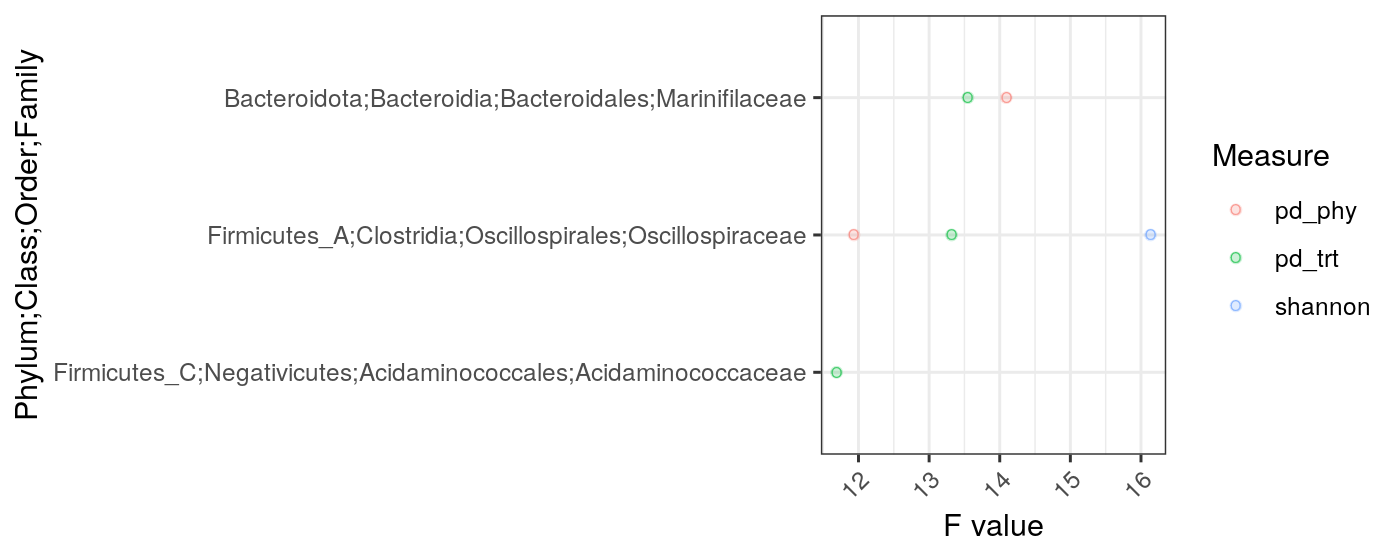

In [151]:
p = lmer_res %>%
    dt_filter(Variable == 'BMI') %>%
    dt_filter(Metric != 'nobs') %>%
    dt_filter(Padj < 0.01) %>%
    dt_mutate(mean_F = mean(F_value), by=list(Clade)) %>%
    dt_mutate(Clade = gsub('___', ';', Clade),
              Clade = gsub('^(Bacteria|Archaea);', '', Clade),
              Clade = Clade %>% reorder(mean_F)) %>%
    ggplot(aes(Clade, F_value, color=Metric)) +
    geom_point(alpha=0.2) +
    geom_point(alpha=0.6, shape='O') +
    scale_color_discrete('Measure') +
    labs(x='Phylum;Class;Order;Family', y='F value') +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    ) +
    coord_flip() 

p.dims(7,2.8)
plot(p)

# sessionInfo

In [65]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Georg_animal_feces/envs/phyloseq-phy/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] LeyLabRMisc_0.1.3 lmerTest_3.1-1    lme4_1.1-21       Matrix_1.2-18    
 [5] PhyloMeasures_2.1 vegan_2.5-6       lattice_0.20-38   permute_0.9-5    
 [9] phyloseq_1.30.0   ape_5.3           tidytable_0.3.2   data.table_1.12.8
[13] ggplot2_3.2.1     tidyr_1.0.0       dplyr_0